<a href="https://colab.research.google.com/github/lior9005/deep-learning/blob/main/Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADL HW2 - PCA and Autoencoders
In this assignment you will implement two dimensionality reduction schemes
we saw in class:
1. Principal Component Analysis (PCA)
2. Autoencoder

You will also implement an image denoising model to enhance the performance of a simple MLP classifier.

The data used in the following exercises is a subset of the MNIST dataset.
Randomly sample 10,000 images from MNIST train set (you may set a random.seed).

# Submission Date: 05.01.2025
Submit the already-run notebook.


In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

# EX1. PCA dimensionality reduction (10pts)

1. Implement the PCA procedure in the function ```perform_PCA()```.

Useful functions:
```
sklearn.preprocessing.StandardScaler
scipy.linalg.eigh
numpy.matmul
```
The input should be in vector form (i.e., flatten the input images beforehand).

2. Project the data to 2D, i.e, $\mathbb{R}^{784}↦ \mathbb{R}^2$.
3. Scatter plot the data using the 2D projection and class labels. You'll need to implement ```plot_projected_data()```


In [78]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import matplotlib.pyplot as plt

def perform_PCA(X, n_components):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    covariance_matrix = np.cov(X_scaled.T)
    eigenvalues, eigenvectors = eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors_subset = eigenvectors[:, :n_components]
    X_pca = np.matmul(X_scaled, eigenvectors_subset)

    return X_pca

def plot_projected_data(X_pca, labels, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))  # Create if not provided
    else:
        fig = ax.get_figure()

    # Get unique labels and assign a color to each
    unique_labels = np.unique(labels)
    colors = plt.colormaps['viridis'](np.linspace(0, 1, len(unique_labels)))

    # Scatter plot with discrete colors
    for i, label in enumerate(unique_labels):
        plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1],
                    c=[colors[i]], label=label, s=30)

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Class Label')
    plt.show()
    return fig

In [79]:
# For EX5, Please use the (0.5, 0.5) normalization value, as
# they were used for training the MLP
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Sample 10K images
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

trainloader = DataLoader(train_subset , batch_size=256, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


using  cuda
Images shape: (10000, 784)
Labels shape: (10000,)


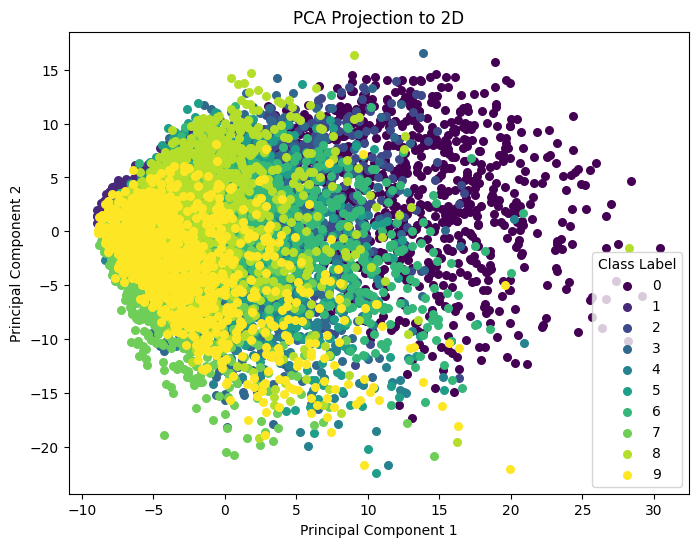

In [80]:
### Your code goes here ###
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using ",device)

def collect_images_and_labels(dataloader):
  # Initialize lists to collect all images and labels
  images = []
  labels = []

  # Iterate through trainloader to extract batches
  for batch_images, batch_labels in trainloader:
      # Flatten images from (256, 1, 28, 28) -> (256, 784)
      batch_images = batch_images.view(batch_images.size(0), -1)  # Flatten to 2D
      images.append(batch_images.cpu().numpy())  # Move to CPU and convert to NumPy
      labels.append(batch_labels.cpu().numpy())  # Convert labels to NumPy

  # Combine all batches into a single array
  images = np.vstack(images)
  labels = np.hstack(labels)

  # Verify shapes
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)
  return images, labels

images, labels = collect_images_and_labels(trainloader)
pca_data = perform_PCA(images,2)
PCA_plot = plot_projected_data(pca_data,labels, "PCA Projection to 2D")

# EX2 Autoencoder (AE) (15pts)
1. Implement a fully-connected Autoencoder. The encoder and decoder should have 2 layers each. Use ReLU activation function.
2. The so-called 'code' should be two-dimensional. In other words, the output of the encoder should be 2.
3. Plot the training loss.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [81]:
class MLP_AE(nn.Module):
    def __init__(self):
      super(MLP_AE, self).__init__()
      self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 2))
      self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28))

    def forward(self,x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    loss_list = []
    with tqdm(total=epochs, unit="epoch", position=0, leave=True) as pbar:
      for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            images = images.view(images.shape[0], -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss/len(train_loader))
        pbar.set_postfix(loss=running_loss/len(train_loader))
        pbar.update(1)
    plot_loss(loss_list)

def plot_loss(loss_list):
  plt.plot(loss_list)
  plt.grid()
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.title("Loss")

  0%|          | 0/25 [00:00<?, ?epoch/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


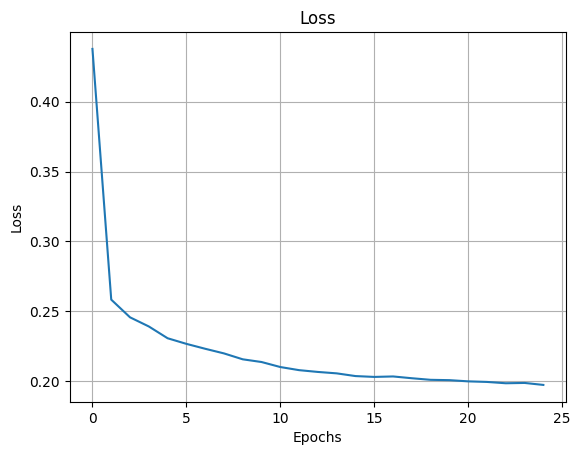

In [82]:
### Your code goes here ###
AE_model = MLP_AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(AE_model.parameters(), lr=0.001)
train(AE_model, trainloader, criterion, optimizer, 25)


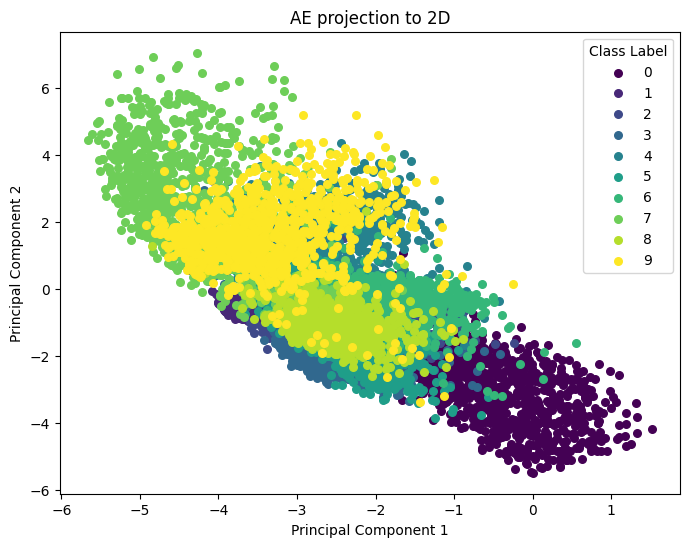

In [83]:
def encode_and_collect(model, data_loader=trainloader):
    model.eval()
    encoded_samples = []
    sample_labels = []

    for batch_data, batch_labels in data_loader:
        with torch.no_grad():
            flattened_data = batch_data.view(batch_data.shape[0], -1).to(device)
            encoded_batch = model.encoder(flattened_data)
            encoded_samples.append(encoded_batch.cpu().numpy())
            sample_labels.append(batch_labels.cpu().numpy())

    all_encoded_data = np.concatenate(encoded_samples, axis=0)
    all_labels = np.concatenate(sample_labels, axis=0)

    return all_encoded_data, all_labels

AE_encoded_data, AE_data_labels = encode_and_collect(AE_model)
AE_plot = plot_projected_data(AE_encoded_data, AE_data_labels, "AE projection to 2D")

# EX3 Linear Autoencoder (15pts)
1. Follow the steps of EX2, but remove the nonlinear activation functions.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [84]:
class Linear_AE(nn.Module):
    def __init__(self):
      super(Linear_AE, self).__init__()
      self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 2),
            )
      self.decoder = nn.Sequential(
            nn.Linear(2, 28 * 28)
            )

    def forward(self,x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

  0%|          | 0/25 [00:00<?, ?epoch/s]

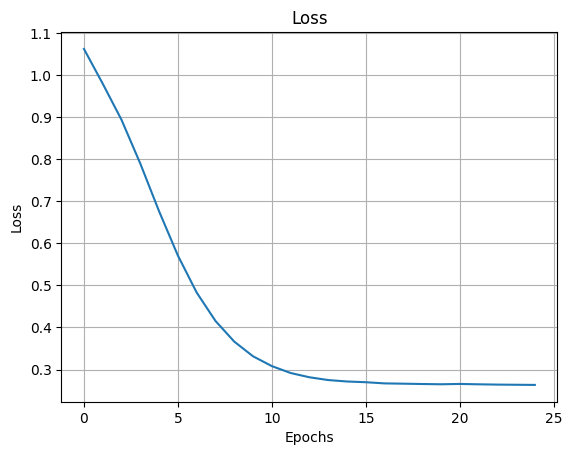

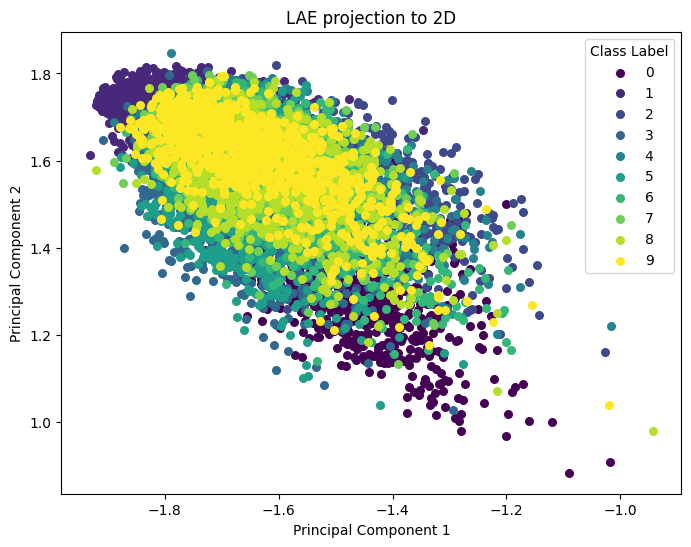

In [85]:
### Your code goes here ###
LAE_model = Linear_AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(LAE_model.parameters(), lr=0.001)
train(LAE_model, trainloader, criterion, optimizer, 25)

LAE_encoded_data, LAE_data_labels = encode_and_collect(LAE_model)
LAE_plot = plot_projected_data(LAE_encoded_data, LAE_data_labels, "LAE projection to 2D")

# EX 4 - Discussion (10pts)
1. Write a new plotting function and plot the results side-by-side using subplots.
2. Given the three figures and what we've learned about PCA and AE, answer what are the difference/similarites between the models? How is that indicated in the results?


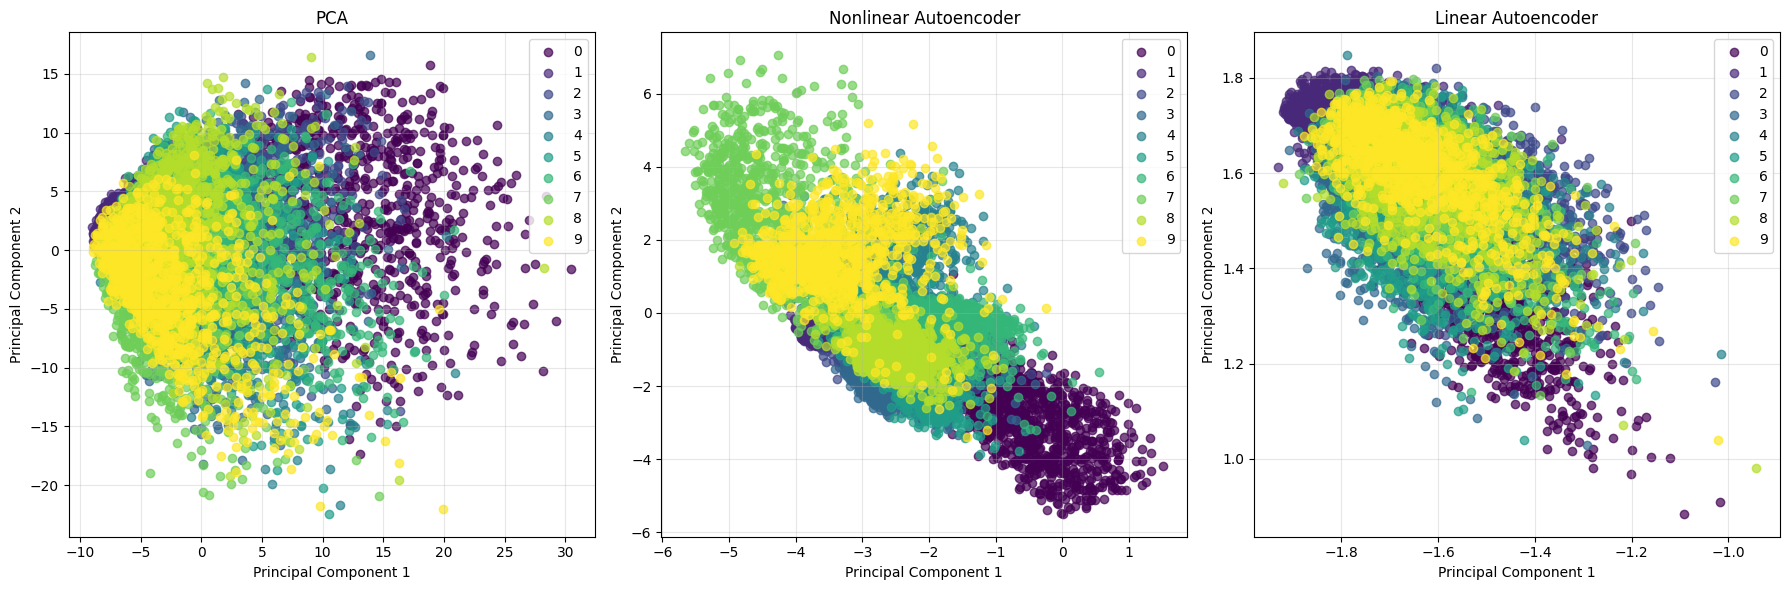

In [86]:
def visualize_projections(PCA_data, PCA_labels, AE_data, AE_labels, LAE_data, LAE_labels):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    PC1 = "Principal Component 1"
    PC2 = "Principal Component 2"
    datasets = [
        (PCA_data, PCA_labels, "PCA", PC1, PC2),
        (AE_data, AE_labels, "Nonlinear Autoencoder",  PC1, PC2),
        (LAE_data, LAE_labels, "Linear Autoencoder",  PC1, PC2)
    ]
    unique_labels = np.unique(np.concatenate([PCA_labels, AE_labels, LAE_labels]))
    colors = plt.colormaps['viridis'](np.linspace(0, 1, len(unique_labels)))
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    for i, (data, labels, title, xlabel, ylabel) in enumerate(datasets):
        ax = axes[i]
        for label in unique_labels:
            points = data[labels == label]
            if points.size > 0:
                ax.scatter(points[:, 0], points[:, 1], c=[color_map[label]], label=f"{label}", alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

visualize_projections(pca_data, labels, AE_encoded_data, AE_data_labels, LAE_encoded_data, LAE_data_labels)


# EX 4 - Discussion answer:
1. **PCA**

  PCA is a linear technique for dimensionality reduction that identifies directions in the data that capture the most variance. It doesn't rely on learned parameters. From the visual plot, it is evident that the data points are somewhat scattered, and class separation is less distinct compared to the autoencoders.

2. **Nonlinear Autoencoder**

  The nonlinear autoencoder leverages activation functions, such as ReLU, to model complex relationships in the data. Since it relies on learned parameters, it can identify and capture intricate patterns in the data.
  Compared to PCA, it tends to form more compact and distinct clusters, signifying better recognition of class-specific patterns. This suggests that the nonlinear autoencoder excels in capturing complex relationships.

3. **Linear Autoencoder**

  Unlike its nonlinear counterpart, the linear autoencoder does not use activation functions, limiting it to linear transformations. Nevertheless, it is trained with learned parameters, which gives it an edge over PCA.
  The plot suggests that it achieves slightly improved results over PCA, with somewhat better class separation. The results are comparable to those of the nonlinear autoencoder, but less distinct.

4. **Comparisons and Key Insights**

  Both types of autoencoders rely on learned parameters, enabling them to perform better than PCA when clustering similar classes.
  All methods demonstrated a degree of success in clustering class-specific data points.

  Autoencoders vs. PCA:
  
  Autoencoders, both linear and nonlinear, performed better in distinguishing between different classes, while PCA struggled to achieve the same level of separation.





# EX 5 - Denoising AE and Classification (50pts.)
In this section you will implement and train a denosing AE to clean corrupted MNIST images.
You are given a trained MLP model (from DL PS1) with ~94% test set accuracy on the cleaned images. Again, work with only 10k images (a subset of the train set).
Your tasks are as follows:
0. Load the mlp.pth file to your project (not google drive dir) and initiate the MLP model with the trained weights.
1. Compute the test set accuracy for the clean and corrupted datasets.
2. Implemented and train autoencoder to remove the noise.
3. Visualize the results for 10 images, one for each digit (original image, corrupted image, clean image).
4. Compute the test set accuracy on the cleaned/denoised corrupted test set. Due to the randomness of the gaussian noise, run the procedure 5 times and take the average accuracy.

You **may not re-train** the classification network or train a new model for classification task.

There is **no need** to submit the trained model weights.

### Grading for this section:
```python
50pts = max(cleaned image accuracy + 10, 100)*0.5 #(i.e, accuracy >= 90% will give you a full grade).
```

You will also be evaluated on the quality of your code and apporach.

## Load trained model

In [88]:
# MLP classifier from DL PS1 - DO NOT CHANGE
mlp_clf = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))


<ipython-input-88-310ad3651e44>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))


<All keys matched successfully>

## Data and functions

In [89]:
# Noise function - DO NOT CHANGE
def add_gaussian_noise(images, mean=0.0, std=2):
    noise = torch.randn(images.size()) * std + mean
    noisy_images = images + noise
    return noisy_images


# Accuracy - DO NOT CHANGE
def compute_accuracy(model, testloader, denoise_model=None, add_noise=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # False for clean images, True for corrupted/noisy
            if add_noise:
              images = add_gaussian_noise(images)
            # Denoise the image before the classifier
            if denoise_model is not None:
              images = denoise_model(images)
            # reshape to vector form for the MLP
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy



In [90]:
# Compute and print test accuracy for clean and corrupted images
clean_acc = compute_accuracy(mlp_clf, testloader)
corrupted_acc = compute_accuracy(mlp_clf, testloader, add_noise=True)
print(f"Clean images accuracy: {clean_acc:.2f}%")
print(f"Corrupted images accuracy: {corrupted_acc:.2f}%")

Clean images accuracy: 93.98%
Corrupted images accuracy: 59.00%


  0%|          | 0/200 [00:00<?, ?epoch/s]

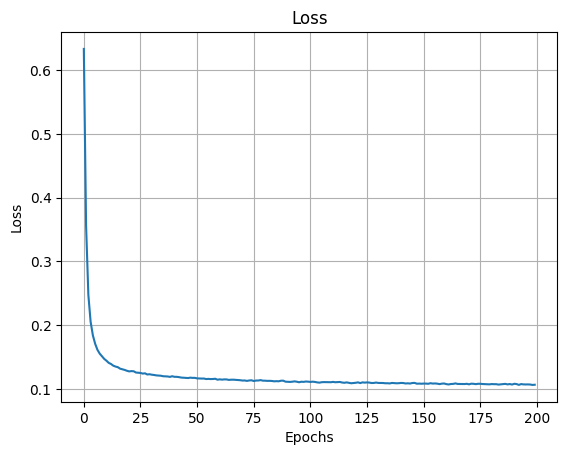

In [94]:
### Your code goes here ###
class MLPv2_AE(nn.Module):
    def __init__(self):
        super(MLPv2_AE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),#normalizes the activations (output of a convolutional layer) for each channel over a mini-batch.
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
            nn.ReLU()

        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=2),
            nn.Tanh()
    )


    def forward(self,x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    loss_list = []
    with tqdm(total=epochs, unit="epoch", position=0, leave=True) as pbar:
      for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            noisy_images = add_gaussian_noise(images)
            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss/len(train_loader))
        pbar.set_postfix(loss=running_loss/len(train_loader))
        pbar.update(1)
    plot_loss(loss_list)

model = MLPv2_AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, trainloader, criterion, optimizer, 200)


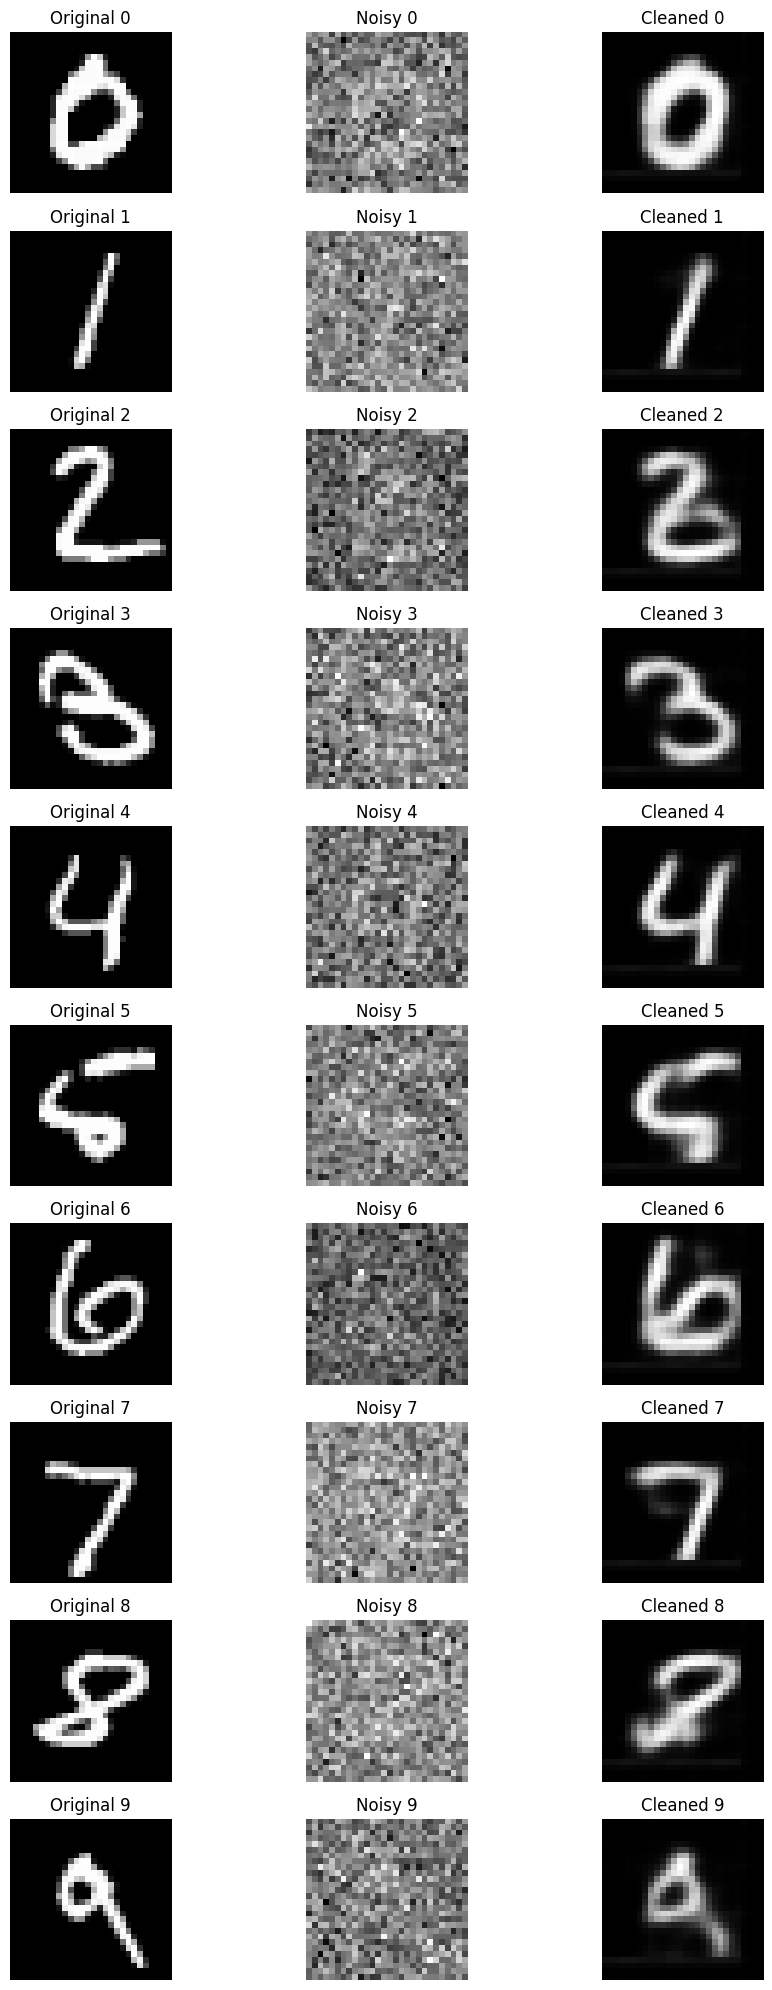

In [95]:
def plot_results(model, test_loader):
    fig, axes = plt.subplots(10, 3, figsize=(10, 20))  # 10 rows for digits 0-9
    model.eval()

    digit_images = {}  # Store one image for each digit
    cleaned_images = {}  # Store the cleaned images for each digit
    # Collect one image for each digit
    for batch_images, labels in test_loader:
        for i in range(len(labels)):
            digit = labels[i].item()
            if digit not in digit_images:
                digit_images[digit] = batch_images[i]
        if len(digit_images) == 10:  # We have all digits
            break

    # Process and plot each digit's images
    for digit in range(10):
        image = digit_images[digit].unsqueeze(0)  # Add batch dimension
        noisy_image = add_gaussian_noise(image)

        # Flatten before passing to the model
        with torch.no_grad():
            cleaned_image = model(noisy_image)
        # Reshape back to original shape
        cleaned_image = cleaned_image.view(image.shape)
        cleaned_images[digit] = cleaned_image
        # Plot images for the current digit
        axes[digit, 0].imshow(image.squeeze(), cmap='gray')
        axes[digit, 0].set_title(f'Original {digit}')
        axes[digit, 0].axis('off')

        axes[digit, 1].imshow(noisy_image.squeeze(), cmap='gray')
        axes[digit, 1].set_title(f'Noisy {digit}')
        axes[digit, 1].axis('off')

        axes[digit, 2].imshow(cleaned_image.squeeze(), cmap='gray')
        axes[digit, 2].set_title(f'Cleaned {digit}')
        axes[digit, 2].axis('off')


    plt.tight_layout()
    plt.show()

    return cleaned_images
cleaned_images = plot_results(model, testloader)


In [96]:
acc = 0.0;
for i in range (5):
  acc += compute_accuracy(mlp_clf, testloader, denoise_model=model, add_noise=True)
print(f"Clean images accuracy: {acc/5:.2f}%")

Clean images accuracy: 84.87%
